# Performing NNSIM on the 2D Flume Case

The morphological dynamic is not considered

Only one TI is applied

The segmentation is applied as the auxiliary variable

Dec. 26, 2021

In [1]:
# import necessary package
import matplotlib.pyplot as plt
import numpy as np

import time

from PIL import Image

from scipy.spatial import distance
from scipy.stats import entropy

from sklearn.decomposition import PCA


from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm

from scipy import ndimage

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

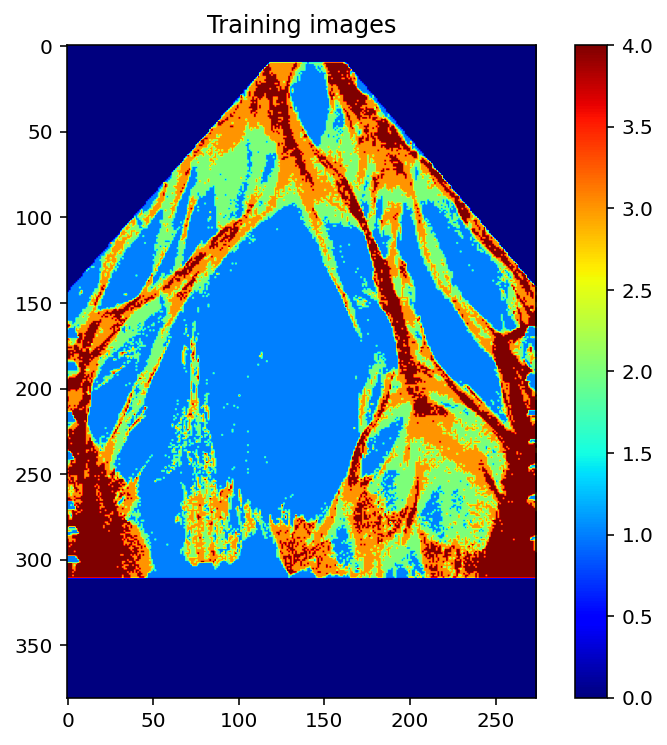

In [2]:
TI_Height = 381
TI_Width = 274

TrainingImage = np.loadtxt(fname='FlumeData_TrainingImage_4Categories.txt',
                  dtype=int,
                  delimiter=',').reshape((TI_Height,TI_Width))

plt.figure(figsize=(7,6))
plt.imshow(TrainingImage,cmap='jet')
plt.title(f'Training images')
plt.colorbar()
plt.show()

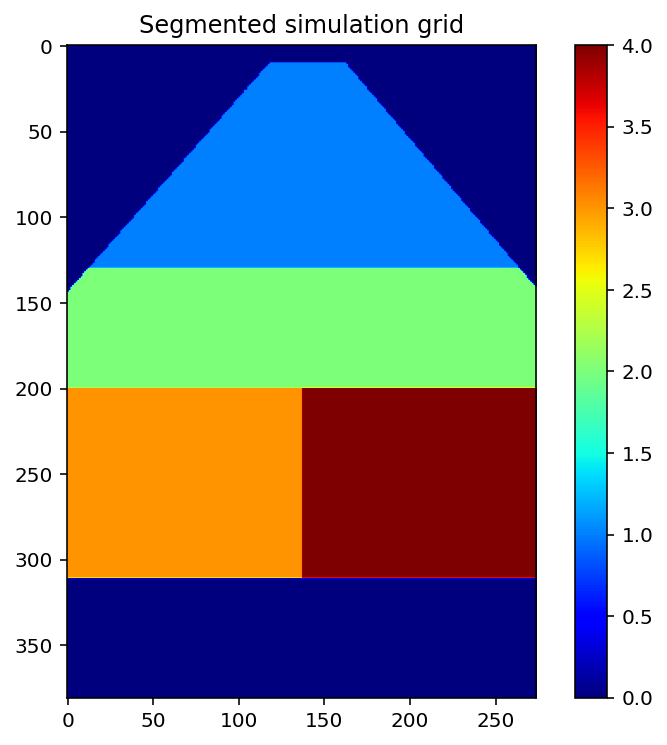

In [3]:
# read the segmented image

FlumeImage_Segmented = np.loadtxt(fname='FlumeData_Segmentation.txt',
                  dtype=int,
                  delimiter=',').reshape((TI_Height,TI_Width))

# FlumeImage_Segmented = np.loadtxt(fname='FlumeData_Mask.txt',
#                   dtype=int,
#                   delimiter=',').reshape((TI_Height,TI_Width))

plt.figure(figsize=(7,6))
plt.imshow(FlumeImage_Segmented, cmap='jet')
plt.title('Segmented simulation grid')
plt.colorbar()
plt.show()

In [4]:
def TemplatePointSequence(template_radius_y,
                          template_radius_x,
                          grid_factor):
    '''determine the sequence about how to create a pattern'''
    
    sequence_y = []
    sequence_x = []
    sequence_distance = []
    
    for point_y in range(-template_radius_y,template_radius_y+1):
        for point_x in range(-template_radius_x,template_radius_x+1):
            sequence_y.append(point_y*grid_factor)
            sequence_x.append(point_x*grid_factor)
            sequence_distance.append(np.sqrt(point_y*point_y+point_x*point_x))
    
    sequence_y = np.array(sequence_y).astype(int)
    sequence_x = np.array(sequence_x).astype(int)
    sequence_distance = np.array(sequence_distance)
            
    rank = np.argsort(sequence_distance)
    
    sequence_y = sequence_y[rank]
    sequence_x = sequence_x[rank]
    
    sequence_y = np.delete(arr=sequence_y,obj=0)
    sequence_x = np.delete(arr=sequence_x,obj=0)
    
    return sequence_y.tolist(), sequence_x.tolist()

In [5]:
def ExtractPattern_Training(domain2D_list,
                            center_y,center_x,
                            sequence_y,sequence_x):
    
    '''extract a pattern from training image based on a given location'''
    
    pattern = []
    for relative_y, relative_x in zip(sequence_y,sequence_x):
        pattern.append(domain2D_list[center_y+relative_y][center_x+relative_x])
    return np.array(pattern)

In [6]:
def ExtractPattern_Simulation(domain2D_list,
                              domain_height,domain_width,
                              center_y,center_x,
                              sequence_y,sequence_x,
                              unknownSymbol):
    
    '''extract a pattern from simulation grid based on a given location'''
    
    
    pattern = []
    for relative_y, relative_x in zip(sequence_y,sequence_x):
        point_y = center_y + relative_y
        point_x = center_x + relative_x
        if(point_y>=0 and point_y<domain_height and point_x>=0 and point_x<domain_width):
            pattern.append(domain2D_list[point_y][point_x])
        else:
            pattern.append(unknownSymbol)
    pattern = np.array(pattern)
    knownAmount = np.argwhere(pattern != unknownSymbol).shape[0]
    return pattern, knownAmount

In [7]:
def ExtractPattern_Simulation_Magnet(domain2D_list,
                                     domain_height,
                                     domain_width,
                                     center_y,
                                     center_x,
                                     template_knn,
                                     template_radius_y,
                                     template_radius_x,
                                     template_size,
                                     unknownSymbol,
                                     uninterestedSymbol):
    
    '''extract a pattern from simulation grid based on a given location'''
    
    searching_location = []
    searching_value = []
    for relative_y in range(-template_radius_y,template_radius_y+1):
        for relative_x in range(-template_radius_x, template_radius_x+1):
            point_y = center_y + relative_y
            point_x = center_x + relative_x
            
            if(point_y>=0 and point_y<domain_height and point_x>=0 and point_x<domain_width):
                if(domain2D_list[point_y][point_x] != unknownSymbol and
                   domain2D_list[point_y][point_x] != uninterestedSymbol):
                    
                    searching_value.append(domain2D_list[point_y][point_x])
                    searching_location.append(relative_y)
                    searching_location.append(relative_x)
            
    searching_location = np.array(searching_location).reshape((-1,2))
    
    neigh_dist, neigh_index  = template_knn.kneighbors(X = searching_location)
    neigh_dist = neigh_dist.reshape(-1)
    neigh_index = neigh_index.reshape(-1)
    
    pattern = [unknownSymbol] * template_size
    magnet_dist = [999999] * template_size
    
    for dist, index, value in zip(neigh_dist, neigh_index, searching_value):
        if(pattern[index] == unknownSymbol):
            pattern[index] = value
            magnet_dist[index] = dist
        elif(magnet_dist[index] > dist):
            pattern[index] = value
            magnet_dist[index] = dist
            
    knownAmount = np.argwhere(pattern != unknownSymbol).shape[0]

    return np.array(pattern), knownAmount

In [8]:
def ConstructPatternBase_Multigrid(TI_list,
                                   TI_Height,TI_Width,
                                   TI_Segmented,
                                   Target_area,
                                   sequence_y, sequence_x,
                                   template_radius_y,template_radius_x, 
                                   grid_factor,
                                   uninterestedSymbol):
    
    '''construct pattern database within the multi-grid framework'''
    
    # the dimension of pattern
    patternSize = len(sequence_y)   
    
    PatternBase = []
    Pattern_label = []
    
    locations = np.argwhere(TI_Segmented == Target_area).reshape((-1,2))
    locations_y = locations[:,0]
    locations_x = locations[:,1]
    
    for center_y, center_x in zip(locations_y, locations_x):
        
        if(center_y<grid_factor*template_radius_y or center_y>=TI_Height-grid_factor*template_radius_y):
            continue
        if(center_x<grid_factor*template_radius_x or center_x>=TI_Width-grid_factor*template_radius_x):
            continue
        
        # extract a pattern
        pattern = ExtractPattern_Training(domain2D_list=TI_list,
                                          center_y=center_y,
                                          center_x=center_x,
                                          sequence_y=sequence_y,
                                          sequence_x=sequence_x)
        if(np.argwhere(pattern == uninterestedSymbol).shape[0] != 0):
            '''there is uninterested points in this pattern'''
            continue
    
        # store primary pattern in database
        PatternBase.extend(pattern.tolist())
        Pattern_label.append(TI_list[center_y][center_x])
            
    PatternBase = np.array(PatternBase).astype(int)
    PatternBase = PatternBase.reshape((-1,patternSize))
        
    return PatternBase, np.array(Pattern_label)

In [9]:
def Fast_condensed_nearest_neighbor(Dataset,
                                    Dataset_labels,
                                    facies_amount):
    
    '''carry out fast condensed nearest neighbor (FCNN) to remove noisy patterns'''
    
    Num_neighbors = 3
    FCNN_Iteration_Max = 30
    
    
    # find the centroids
    # centroid is the mean value
    Centroids = []
    for index_label in range(1, facies_amount+1):
        centroids = np.median(Dataset[ Dataset_labels == index_label ],axis=0).tolist()
        Centroids.extend(centroids)
    
    Centroids = np.array(Centroids).reshape((facies_amount,-1))

    knn_instance = NearestNeighbors(n_neighbors = 1,
                                        algorithm = 'ball_tree',
                                        metric = 'hamming')

    knn_instance.fit(X=Dataset)
    
    neighbors_distance, neighbors_index = knn_instance.kneighbors(X=Centroids)
    
    S_indices = np.copy(neighbors_index).reshape(-1)
    S = np.copy(Dataset[S_indices])    
    
    iteration_index = 0
    
    Dataset_element_num = Dataset.shape[0]
    
    knn_classifier_instance = KNeighborsClassifier(n_neighbors = 1,
                                                      algorithm = 'auto',
                                                      metric = 'hamming',
                                                      n_jobs = 6)
    
    
#     # The only one purpose of PCA is to visulize the FCNN process
#     pca = PCA(n_components=2)
#     pca.fit(Dataset)    
#     Dataset_decomposed = pca.transform(Dataset)[:,0:2]
    
    for iteration_index in tqdm(range(FCNN_Iteration_Max)):
        
        if(S_indices.shape[0] < Num_neighbors):
            knn_classifier_instance = KNeighborsClassifier(n_neighbors = 1,
                                                      algorithm = 'auto',
                                                      metric = 'hamming',
                                                      n_jobs = 6)
        else:
            knn_classifier_instance = KNeighborsClassifier(n_neighbors = Num_neighbors,
                                                      algorithm = 'auto',
                                                      metric = 'hamming',
                                                      n_jobs = 6)
        
        T_indices = np.setdiff1d(np.arange(0,Dataset_element_num,1), S_indices)
        T = np.copy(Dataset[T_indices])
        
        knn_classifier_instance.fit(X = S, y=Dataset_labels[S_indices])
        
        labels_predict = knn_classifier_instance.predict(X = T)
        
        difference = Dataset_labels[T_indices] - labels_predict
        
        misclassified_indices = np.argwhere( difference != 0.0  ).reshape(-1)
        
        if(misclassified_indices.shape[0] == 0):
            break
        
        neighbor_distance,\
        misclassified_medoid_indices = knn_classifier_instance.kneighbors(X = T[misclassified_indices])
        misclassified_medoid_indices = np.unique(misclassified_medoid_indices)
        
        
        knn_instance.fit(X = T[misclassified_indices])
        
        neighbors_distance,\
        representative_indices = knn_instance.kneighbors(X = S[misclassified_medoid_indices])
        representative_indices = representative_indices.reshape(-1)
        alpha_S_indices = T_indices[misclassified_indices[representative_indices]].reshape(-1)
        
        S_indices = np.concatenate((S_indices, alpha_S_indices))
        S_indices = np.unique(S_indices)
        
        S = np.copy(Dataset[S_indices])
        
#         print(f'The number of prototype patterns is {S.shape[0]}')

#         plt.scatter(Dataset_decomposed[:,0], Dataset_decomposed[:,1],
#                     c=Dataset_labels, cmap='Greens',
#                     s=20, lw=0,
#                     vmin=-1, vmax=2)
#         plt.scatter(Dataset_decomposed[S_indices,0], Dataset_decomposed[S_indices,1],
#                     c='r',
#                     s=30, lw=0)
#         plt.scatter(Dataset_decomposed[alpha_S_indices,0], Dataset_decomposed[alpha_S_indices,1],
#                     c='b',
#                     s=20, lw=0)
#         plt.xlabel(str('PC1'),fontsize='large')
#         plt.ylabel(str('PC2'),fontsize='large')
#         plt.tick_params(direction='in',labelsize='large')
#         plt.title(f'Iteration {iteration_index} with {S.shape[0]} patterns')
#         plt.show()
        
#         print(f'S indices: {S_indices}')
#         print(f'S labels: {Dataset_labels[S_indices]}')
    
    return np.copy(S_indices)

In [10]:
def RandomSimulationPath(grid_factor,
                         mask_image,
                         uninterestedSymbol):
    '''define the simulation path within the multi-grid framework'''
    
    mask_image_grid = np.copy(mask_image[::grid_factor,::grid_factor])
    unknownPoint = np.argwhere(mask_image_grid != uninterestedSymbol).reshape((-1,2))
    unknownPoint = unknownPoint * grid_factor
    
    simulationPath = np.arange(0,unknownPoint.shape[0],1)
    np.random.shuffle(simulationPath)
    
    simulationPath_y = unknownPoint[simulationPath,0]
    simulationPath_x = unknownPoint[simulationPath,1]
    
    return simulationPath_y.astype(int).tolist(), simulationPath_x.astype(int).tolist()

In [11]:
def InitializeRealization2D_unconditional(domain_height,
                                          domain_width,
                                          mask_image,
                                          sampleRate,
                                          faciesAmount,
                                          unknownSymbol,
                                          uninterestedSymbol):
    
    '''initialize a realization'''
    
    sampleAmount = int(domain_height*domain_width*sampleRate)
    
    hardDataPath = np.arange(domain_height*domain_width)
    np.random.shuffle(hardDataPath)
    hardDataPath = hardDataPath[:sampleAmount]
    hardDataPath_y = hardDataPath // domain_width
    hardDataPath_x = hardDataPath % domain_width
    
    hardDataValue = np.random.randint(low=1,high=faciesAmount+1,size=sampleAmount)
    
    Realization2D = np.full(shape=(domain_height,domain_width), fill_value=unknownSymbol)
    
    for center_y, center_x, value in zip(hardDataPath_y, hardDataPath_x, hardDataValue):
        Realization2D[center_y, center_x] = value
    
    Realization2D[ mask_image==uninterestedSymbol ] = uninterestedSymbol
    
    return Realization2D

In [12]:
def InitializeRealization2D_conditional(domain_height,
                                          domain_width,
                                          TrainingImage_list,
                                          mask_image,
                                          sampleRate,
                                          faciesAmount,
                                          unknownSymbol,
                                          uninterestedSymbol):
    
    '''initialize a realization'''
    
    sampleAmount = int(domain_height*domain_width*sampleRate)
    
    hardDataPath = np.arange(domain_height*domain_width)
    np.random.shuffle(hardDataPath)
    hardDataPath = hardDataPath[:sampleAmount]
    hardDataPath_y = hardDataPath // domain_width
    hardDataPath_x = hardDataPath % domain_width
    
    Realization2D = np.full(shape=(domain_height,domain_width), fill_value=unknownSymbol)
    
    for center_y, center_x in zip(hardDataPath_y, hardDataPath_x):
        value = TrainingImage_list[center_y][center_x]
        Realization2D[center_y, center_x] = value
    
    Realization2D[ mask_image==uninterestedSymbol ] = uninterestedSymbol
    
    return Realization2D

In [13]:
def Simulate_Realizations_BallTree_TeacherStudent(TrainingImage,
                                     TrainingImage_list,
                                     TI_Height,
                                     TI_Width,
                                     SG_Amount,
                                     SG_Height,
                                     SG_Width,
                                     SG_Segmented,
                                     Segmentation_Number,
                                     MultiGrid,
                                     Template_radius_y,
                                     Template_radius_x,
                                     Num_neighbors_searching,
                                     Num_neighbors_thresholding,
                                     FaciesAmount,
                                     UnknownSymbol,
                                     UninterestedSymbol,
                                     SG_Amount_teacher,
                                     Divergence_Threshold):
    
    print('\n\n\nFCNN selection, Teacher student improvement, and Ball tree searching')
    
    # unconditional simulation
    RealizationSet = []
    for index_realization in range(SG_Amount):    
#         SimulationGrid = InitializeRealization2D_unconditional(domain_height = SG_Height,
#                                                                domain_width = SG_Width,
#                                                                sampleRate = 0.01,
#                                                                mask_image = SG_Segmented,
#                                                                faciesAmount = FaciesAmount,
#                                                                unknownSymbol = UnknownSymbol,
#                                                                uninterestedSymbol = UninterestedSymbol)
        
        SimulationGrid = InitializeRealization2D_conditional(domain_height = SG_Height,
                                                              domain_width = SG_Width,
                                                              TrainingImage_list = TrainingImage_list,
                                                              mask_image = SG_Segmented,
                                                              sampleRate = 0.05,
                                                              faciesAmount = FaciesAmount,
                                                              unknownSymbol = UnknownSymbol,
                                                              uninterestedSymbol = UninterestedSymbol)
        RealizationSet.extend(SimulationGrid.tolist())
        
    RealizationSet = np.array(RealizationSet)
    RealizationSet = RealizationSet.reshape((SG_Amount, SG_Height, SG_Width))
    
    SG_Segmented_list = SG_Segmented.tolist()
    null_array = []
    
    # multigrid strategy
    for grid in np.arange(start=MultiGrid, stop=-1, step=-1):
        
        print(f'Grid {grid}:')
        
        starting_time = time.time()
        
        grid_factor = 2**grid
        
        # define the sequence to collect hard data
        sequence_y, sequence_x = TemplatePointSequence(template_radius_y=Template_radius_y,
                                                  template_radius_x=Template_radius_x,
                                                  grid_factor=grid_factor)
        pattern_size = len(sequence_y)
        
        template_location = np.concatenate((np.array(sequence_y).reshape(-1,1),np.array(sequence_x).reshape(-1,1)),axis=1)
        template_knn = NearestNeighbors(n_neighbors = 1,
                                        algorithm = 'ball_tree',
                                        metric='euclidean')
        template_knn.fit(template_location)
        
        
        # constructure pattern dataset in each local area
        Dataset_segmentation = []
        Labels_segmentation = []
        
        BallTree_teacher = []
        BallTree_student = []
        Student_resample_indices = []
        for index_segment in range(0,Segmentation_Number+1):
            
            Dataset, Labels = ConstructPatternBase_Multigrid(TI_list = TrainingImage_list,
                                                             TI_Height = TI_Height,
                                                             TI_Width = TI_Width,
                                                             TI_Segmented = SG_Segmented,
                                                             Target_area = index_segment,
                                                             sequence_y = sequence_y,
                                                             sequence_x = sequence_x,
                                                             template_radius_y = Template_radius_y,
                                                             template_radius_x = Template_radius_x, 
                                                             grid_factor = grid_factor,
                                                             uninterestedSymbol = UninterestedSymbol)
        
            Labels = Labels.astype(int)
            
            if(Dataset.shape[0] == 0):
                Dataset_segmentation.append(null_array)
                Labels_segmentation.append(null_array)
                BallTree_teacher.append(null_array)
                BallTree_student.append(null_array)
                Student_resample_indices.append(null_array)
                
            else:
            
                Dataset_segmentation.append(Dataset)
                Labels_segmentation.append(Labels)

                FCNN_resample_indices = Fast_condensed_nearest_neighbor(Dataset = Dataset,
                                                                            Dataset_labels = Labels,
                                                                            facies_amount = FaciesAmount)

                student_indices = np.copy(FCNN_resample_indices).tolist()


                ball_tree_teacher = NearestNeighbors(n_neighbors = Num_neighbors_searching,
                                            algorithm = 'ball_tree',
                                            metric='hamming')
                ball_tree_teacher.fit(Dataset)

                ball_tree_student = NearestNeighbors(n_neighbors = Num_neighbors_searching,
                                                    algorithm = 'ball_tree',
                                                    metric='hamming')   

                BallTree_teacher.append(ball_tree_teacher)
                BallTree_student.append(ball_tree_student)
                Student_resample_indices.append(student_indices)
            
                print(f'The number of patterns before FCNN {Dataset.shape[0]}')
                print(f'The number of patterns after  FCNN {FCNN_resample_indices.shape}')
            
        ending_time = time.time()
        print(f'The FCNN program costs {ending_time-starting_time} seconds')
        
        # teaching step
        print('Teacher simulation')
        for index_realization in tqdm(range(SG_Amount_teacher)):
            
            # get initial realization
            Realization2D_list = np.copy(RealizationSet[index_realization]).tolist()
            
#             plt.figure(figsize=(7,6))
#             plt.imshow(np.array(Realization2D_list)[::grid_factor,::grid_factor], cmap='jet')
#             plt.colorbar()
#             plt.title('Initialized Grid')
#             plt.show()
            
            # update student ball tree
            Labels_student = []
            for index_segment in range(0,Segmentation_Number+1):
                
                if(len(Student_resample_indices[index_segment])==0):
                    Labels_student.append(null_array)
                else:
                
                    student_resample_indices = Student_resample_indices[index_segment]
                    
                    labels_student = np.copy(Labels_segmentation[index_segment][student_resample_indices])
                    Labels_student.append(labels_student)

                    dataset_student = np.copy(Dataset_segmentation[index_segment][student_resample_indices])
                    BallTree_student[index_segment].fit(dataset_student)
            
            # define a random simulation path
            simulationPath_y_list, simulationPath_x_list = RandomSimulationPath(grid_factor = grid_factor,
                                                                      mask_image = SG_Segmented,
                                                                      uninterestedSymbol = UninterestedSymbol)
            
#             for index_point in tqdm(range(len(simulationPath_y_list))):
#                 unknown_y = simulationPath_y_list[index_point]
#                 unknown_x = simulationPath_x_list[index_point]
            
            for unknown_y, unknown_x in zip(simulationPath_y_list, simulationPath_x_list):
                
                if(Realization2D_list[unknown_y][unknown_x]!=UnknownSymbol):
                    continue
                    
                # find an unknown point
                
                if(grid == 0):
                    conditioningPattern, knownAmount = ExtractPattern_Simulation(domain2D_list = Realization2D_list,
                                                                                  domain_height = SG_Height,
                                                                                  domain_width = SG_Width,
                                                                                  center_y = unknown_y,
                                                                                  center_x = unknown_x,
                                                                                  sequence_y = sequence_y,
                                                                                  sequence_x = sequence_x,
                                                                                  unknownSymbol = UnknownSymbol)
                else:
                    conditioningPattern, knownAmount = ExtractPattern_Simulation_Magnet(domain2D_list = Realization2D_list,
                                                                                  domain_height = SG_Height,
                                                                                  domain_width = SG_Width,
                                                                                  center_y = unknown_y,
                                                                                  center_x = unknown_x,
                                                                                  template_knn = template_knn,
                                                                                  template_radius_y = Template_radius_y * grid_factor,
                                                                                  template_radius_x = Template_radius_x * grid_factor,
                                                                                  template_size = pattern_size,
                                                                                  unknownSymbol = UnknownSymbol,
                                                                                  uninterestedSymbol = UninterestedSymbol)
                
                if(knownAmount == 0):
                    # the conditioning pattern does not have known point
                    # randomly assign a value to the simulating point
                    unknown_value = int(np.random.randint(low=1,high=FaciesAmount+1,size=1))
                else:
                    # perform a ball tree search to find comparable pattern
                    conditioningPattern = conditioningPattern.reshape((1,-1))
                    
                    index_segment = SG_Segmented_list[unknown_y][unknown_x]
                    
                    # teacher finding
                    patternDistance,\
                    similarityIndex = BallTree_teacher[index_segment].kneighbors(conditioningPattern)                  
                    patternDistance = patternDistance.reshape(-1)
                    similarityIndex_teacher = similarityIndex.reshape(-1)
                    
                    distance_threshold = patternDistance[Num_neighbors_thresholding]
                    similarityIndex_teacher = similarityIndex_teacher[ patternDistance <= distance_threshold ]
                    occurrence_teacher = np.bincount(Labels_segmentation[index_segment][similarityIndex_teacher],
                                                     minlength=FaciesAmount+1)
                    
                    # simulate the unknown point according to the teacher finding
                    unknown_value = int(np.random.choice(a=Labels_segmentation[index_segment][similarityIndex_teacher],
                                                         size=1)[0])
                    
                    # student finding
                    patternDistance,\
                    similarityIndex = BallTree_student[index_segment].kneighbors(conditioningPattern)                  
                    patternDistance = patternDistance.reshape(-1)
                    similarityIndex_student = similarityIndex.reshape(-1)
                    
                    distance_threshold = patternDistance[Num_neighbors_thresholding]
                    similarityIndex_student = similarityIndex_student[ patternDistance <= distance_threshold ]
                    
                    occurrence_student = np.bincount(Labels_student[index_segment][similarityIndex_student],
                                                     minlength=FaciesAmount+1)
                    
                    
                    
                    # compare teacher and student's performance
                    
                    # cosine distance
                    divergence = distance.cosine(occurrence_teacher, occurrence_student)
                    
                    if(divergence > Divergence_Threshold):
                        # student cannot address this conditioning pattern
                        Student_resample_indices[index_segment].extend(similarityIndex_teacher.tolist())
                    
                Realization2D_list[unknown_y][unknown_x] = unknown_value
            
            # store the simulated result
            RealizationSet[index_realization] = np.copy(np.array(Realization2D_list))
            
            # remove redundant element
            for index_segment in range(0,Segmentation_Number+1):
                student_resample_indices = np.unique(Student_resample_indices[index_segment]).tolist()
                Student_resample_indices[index_segment] = student_resample_indices[:]
                print(f'The number of student set is {len(Student_resample_indices[index_segment])}')
            
        print('Student simulation')
        # update student ball tree
        Labels_student = []
        for index_segment in range(0,Segmentation_Number+1):
            if(len(Student_resample_indices[index_segment])==0):
                Labels_student.append(null_array)
            else:
                student_resample_indices = Student_resample_indices[index_segment]
                
                labels_student = np.copy(Labels_segmentation[index_segment][student_resample_indices])
                Labels_student.append(labels_student)
                
                dataset_student = np.copy(Dataset_segmentation[index_segment][student_resample_indices])
                BallTree_student[index_segment].fit(dataset_student)
                
        for index_realization in tqdm(range(SG_Amount_teacher, SG_Amount)):
            
#             print(f'Student Realization {index_realization}')
            
            Realization2D_list = np.copy(RealizationSet[index_realization]).tolist()
            
            # define a random simulation path
            simulationPath_y_list, simulationPath_x_list = RandomSimulationPath(grid_factor = grid_factor,
                                                                      mask_image = SG_Segmented,
                                                                      uninterestedSymbol = UninterestedSymbol)
            
            for unknown_y, unknown_x in zip(simulationPath_y_list, simulationPath_x_list):
                
                if(Realization2D_list[unknown_y][unknown_x]!=UnknownSymbol):
                    continue
                    
                # find an unknown point
                if(grid == 0):
                    conditioningPattern, knownAmount = ExtractPattern_Simulation(domain2D_list = Realization2D_list,
                                                                                  domain_height = SG_Height,
                                                                                  domain_width = SG_Width,
                                                                                  center_y = unknown_y,
                                                                                  center_x = unknown_x,
                                                                                  sequence_y = sequence_y,
                                                                                  sequence_x = sequence_x,
                                                                                  unknownSymbol = UnknownSymbol)
                else:
                    conditioningPattern, knownAmount = ExtractPattern_Simulation_Magnet(domain2D_list = Realization2D_list,
                                                                                  domain_height = SG_Height,
                                                                                  domain_width = SG_Width,
                                                                                  center_y = unknown_y,
                                                                                  center_x = unknown_x,
                                                                                  template_knn = template_knn,
                                                                                  template_radius_y = Template_radius_y * grid_factor,
                                                                                  template_radius_x = Template_radius_x * grid_factor,
                                                                                  template_size = pattern_size,
                                                                                  unknownSymbol = UnknownSymbol,
                                                                                  uninterestedSymbol = UninterestedSymbol)
                
                if(knownAmount == 0):
                    # the conditioning pattern does not have known point
                    # randomly assign a value to the simulating point
                    unknown_value = int(np.random.randint(low=1,high=FaciesAmount+1,size=1))
                else:
                    # perform a ball tree search to find comparable pattern
                    conditioningPattern = conditioningPattern.reshape((1,-1))
                    
                    index_segment = SG_Segmented_list[unknown_y][unknown_x]
                    
                    # student finding
                    patternDistance,\
                    similarityIndex = BallTree_student[index_segment].kneighbors(conditioningPattern)                  
                    patternDistance = patternDistance.reshape(-1)
                    similarityIndex_student = similarityIndex.reshape(-1)
                    
                    distance_threshold = patternDistance[Num_neighbors_thresholding]
                    similarityIndex_student = similarityIndex_student[ patternDistance <= distance_threshold ]
                    
                    unknown_value = int(np.random.choice(a=Labels_student[index_segment][similarityIndex_student],
                                                         size=1)[0])
            
                    
                Realization2D_list[unknown_y][unknown_x] = unknown_value
            
            RealizationSet[index_realization] = np.copy(np.array(Realization2D_list))
            
    return RealizationSet

In [14]:
MultiGrid = 3

Template_radius_y = 3
Template_radius_x = 3

SimulationGrid_Num = 10
SimulationGrid_Height = TI_Height
SimualtionGrid_Width = TI_Width

Num_neighbors_searching = 101
Num_neighbors_threshold = 2

Facies_Amount = np.max(TrainingImage)

Uninterested_Symbol = 0
Unknown_Symbol = -1

SG_Amount_teacher = min(4,SimulationGrid_Num)
Divergence_Threshold = 0.1

In [15]:
starting_time = time.time()
Realizations_FCNN_BallTree_TeacherStudent = Simulate_Realizations_BallTree_TeacherStudent(TrainingImage = TrainingImage,
                                     TrainingImage_list = TrainingImage.tolist(),
                                     TI_Height = TI_Height,
                                     TI_Width = TI_Width,
                                     SG_Amount = SimulationGrid_Num,
                                     SG_Height = SimulationGrid_Height,
                                     SG_Width = SimualtionGrid_Width,
                                     SG_Segmented = FlumeImage_Segmented,
                                     Segmentation_Number = np.max(FlumeImage_Segmented),
                                     MultiGrid = MultiGrid,
                                     Template_radius_y = Template_radius_y,
                                     Template_radius_x = Template_radius_x,                                          
                                     Num_neighbors_searching = Num_neighbors_searching,
                                     Num_neighbors_thresholding = Num_neighbors_threshold,
                                     FaciesAmount = Facies_Amount,
                                     UnknownSymbol = Unknown_Symbol,
                                     UninterestedSymbol = Uninterested_Symbol,
                                     SG_Amount_teacher = SG_Amount_teacher,
                                     Divergence_Threshold = Divergence_Threshold)
ending_time = time.time()
print(f'The simulation program based on student patterns and ball tree searching cost {ending_time-starting_time} seconds')




FCNN selection, Teacher student improvement, and Ball tree searching
Grid 3:


100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


The number of patterns before FCNN 7590
The number of patterns after  FCNN (3225,)


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


The number of patterns before FCNN 14628
The number of patterns after  FCNN (3689,)


 87%|████████▋ | 26/30 [00:16<00:02,  1.53it/s]


The number of patterns before FCNN 9831
The number of patterns after  FCNN (3259,)


 93%|█████████▎| 28/30 [00:23<00:01,  1.21it/s]


The number of patterns before FCNN 9831
The number of patterns after  FCNN (4449,)
The FCNN program costs 84.73613953590393 seconds
Teacher simulation


 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

The number of student set is 0
The number of student set is 3585
The number of student set is 5006
The number of student set is 3716
The number of student set is 4574


 50%|█████     | 2/4 [00:07<00:07,  3.62s/it]

The number of student set is 0
The number of student set is 3776
The number of student set is 5181
The number of student set is 3843
The number of student set is 4737


 75%|███████▌  | 3/4 [00:10<00:03,  3.53s/it]

The number of student set is 0
The number of student set is 3910
The number of student set is 5242
The number of student set is 3919
The number of student set is 4818


100%|██████████| 4/4 [00:14<00:00,  3.57s/it]


The number of student set is 0
The number of student set is 4045
The number of student set is 5347
The number of student set is 4016
The number of student set is 4929
Student simulation


100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Grid 2:


 93%|█████████▎| 28/30 [00:32<00:02,  1.18s/it]


The number of patterns before FCNN 12245
The number of patterns after  FCNN (4855,)


 93%|█████████▎| 28/30 [00:40<00:02,  1.44s/it]


The number of patterns before FCNN 16953
The number of patterns after  FCNN (4433,)


 80%|████████  | 24/30 [00:21<00:05,  1.14it/s]


The number of patterns before FCNN 12375
The number of patterns after  FCNN (3996,)


 87%|████████▋ | 26/30 [00:28<00:04,  1.11s/it]


The number of patterns before FCNN 12375
The number of patterns after  FCNN (5467,)
The FCNN program costs 126.75876808166504 seconds
Teacher simulation


 25%|██▌       | 1/4 [00:11<00:33, 11.11s/it]

The number of student set is 0
The number of student set is 5764
The number of student set is 7669
The number of student set is 6256
The number of student set is 6511


 50%|█████     | 2/4 [00:23<00:23, 11.63s/it]

The number of student set is 0
The number of student set is 6105
The number of student set is 7898
The number of student set is 6418
The number of student set is 6817


 75%|███████▌  | 3/4 [00:35<00:11, 11.93s/it]

The number of student set is 0
The number of student set is 6505
The number of student set is 8068
The number of student set is 6524
The number of student set is 7055


100%|██████████| 4/4 [00:47<00:00, 11.87s/it]


The number of student set is 0
The number of student set is 6777
The number of student set is 8259
The number of student set is 6643
The number of student set is 7194
Student simulation


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


Grid 1:


 97%|█████████▋| 29/30 [00:43<00:01,  1.49s/it]


The number of patterns before FCNN 14883
The number of patterns after  FCNN (5426,)


 90%|█████████ | 27/30 [00:44<00:04,  1.66s/it]


The number of patterns before FCNN 18023
The number of patterns after  FCNN (4631,)


 73%|███████▎  | 22/30 [00:24<00:09,  1.14s/it]


The number of patterns before FCNN 13755
The number of patterns after  FCNN (4151,)


 87%|████████▋ | 26/30 [00:35<00:05,  1.37s/it]


The number of patterns before FCNN 13755
The number of patterns after  FCNN (5298,)
The FCNN program costs 153.00292420387268 seconds
Teacher simulation


 25%|██▌       | 1/4 [00:42<02:07, 42.36s/it]

The number of student set is 0
The number of student set is 9205
The number of student set is 9605
The number of student set is 8920
The number of student set is 7834


 50%|█████     | 2/4 [01:25<01:25, 42.72s/it]

The number of student set is 0
The number of student set is 9680
The number of student set is 9979
The number of student set is 9113
The number of student set is 8224


 75%|███████▌  | 3/4 [02:11<00:44, 44.32s/it]

The number of student set is 0
The number of student set is 10069
The number of student set is 10205
The number of student set is 9229
The number of student set is 8513


100%|██████████| 4/4 [02:58<00:00, 44.67s/it]


The number of student set is 0
The number of student set is 10380
The number of student set is 10396
The number of student set is 9340
The number of student set is 8735
Student simulation


100%|██████████| 6/6 [02:02<00:00, 20.40s/it]


Grid 0:


100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


The number of patterns before FCNN 16280
The number of patterns after  FCNN (4744,)


 83%|████████▎ | 25/30 [00:30<00:06,  1.23s/it]


The number of patterns before FCNN 18534
The number of patterns after  FCNN (4060,)


 77%|███████▋  | 23/30 [00:21<00:06,  1.07it/s]


The number of patterns before FCNN 14472
The number of patterns after  FCNN (3800,)


 93%|█████████▎| 28/30 [00:29<00:02,  1.04s/it]


The number of patterns before FCNN 14472
The number of patterns after  FCNN (4619,)
The FCNN program costs 122.27910709381104 seconds
Teacher simulation


 25%|██▌       | 1/4 [02:09<06:28, 129.53s/it]

The number of student set is 0
The number of student set is 12619
The number of student set is 11359
The number of student set is 9721
The number of student set is 10890


 50%|█████     | 2/4 [04:50<04:55, 147.87s/it]

The number of student set is 0
The number of student set is 12940
The number of student set is 11605
The number of student set is 9826
The number of student set is 11107


 75%|███████▌  | 3/4 [07:36<02:36, 156.43s/it]

The number of student set is 0
The number of student set is 13175
The number of student set is 11790
The number of student set is 9900
The number of student set is 11252


100%|██████████| 4/4 [10:17<00:00, 154.26s/it]

The number of student set is 0
The number of student set is 13348
The number of student set is 11887
The number of student set is 9986
The number of student set is 11383
Student simulation



100%|██████████| 6/6 [07:07<00:00, 71.18s/it]

The simulation program based on student patterns and ball tree searching cost 1937.3673930168152 seconds


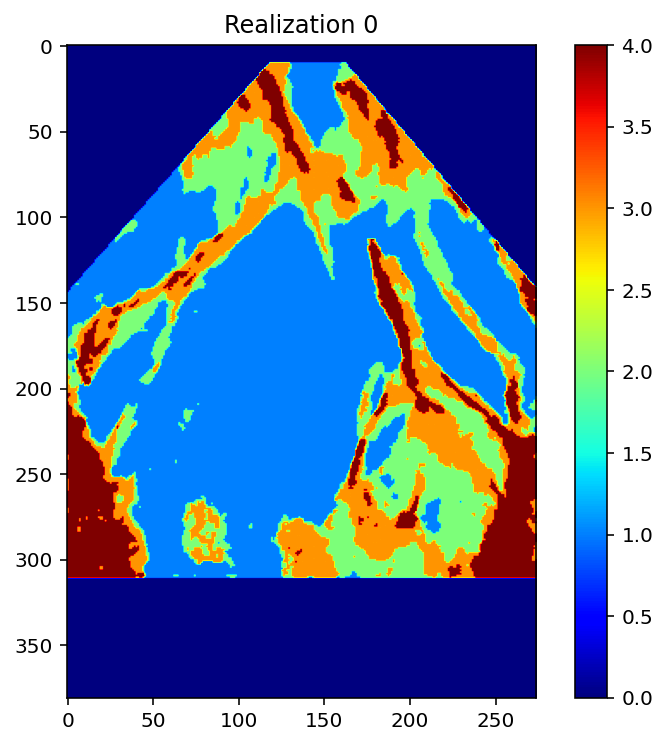

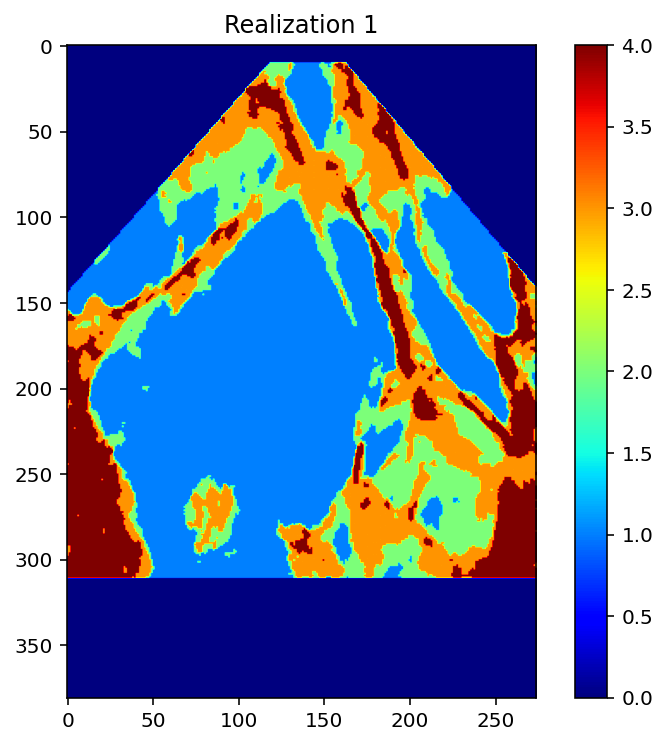

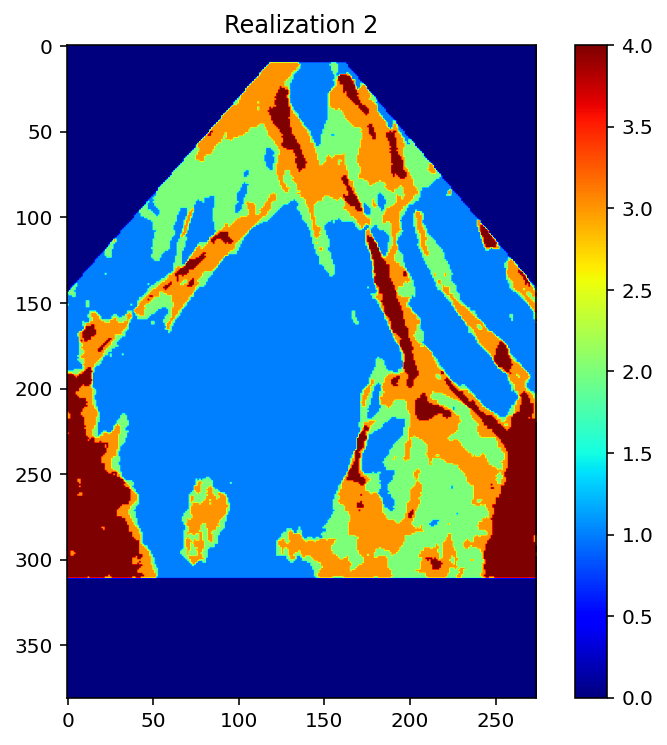

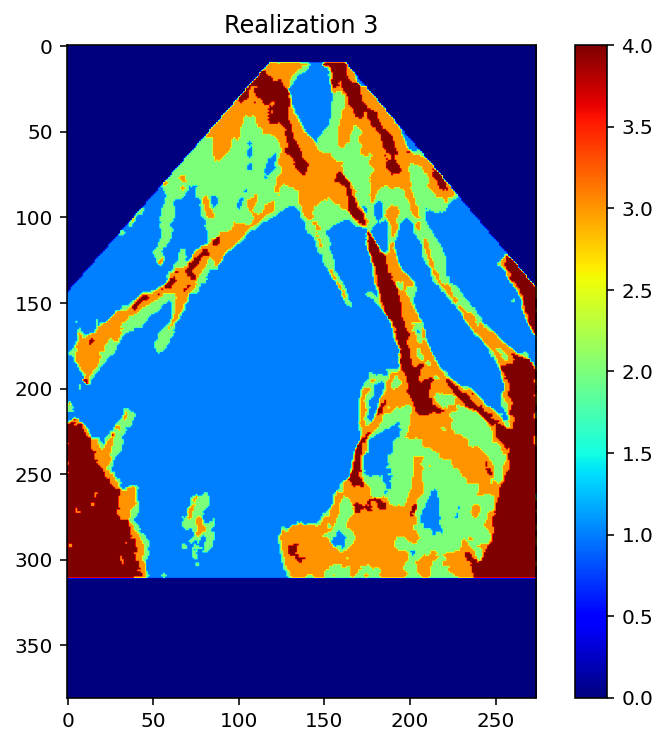

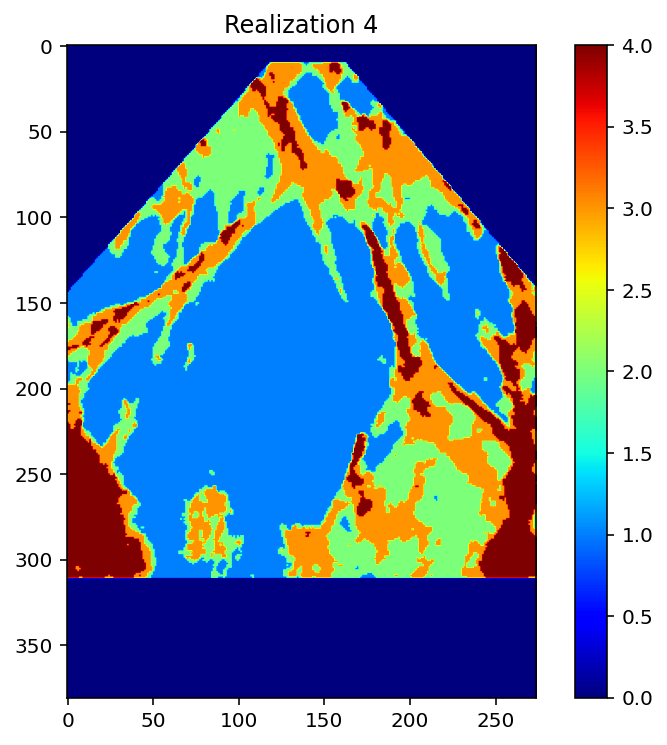

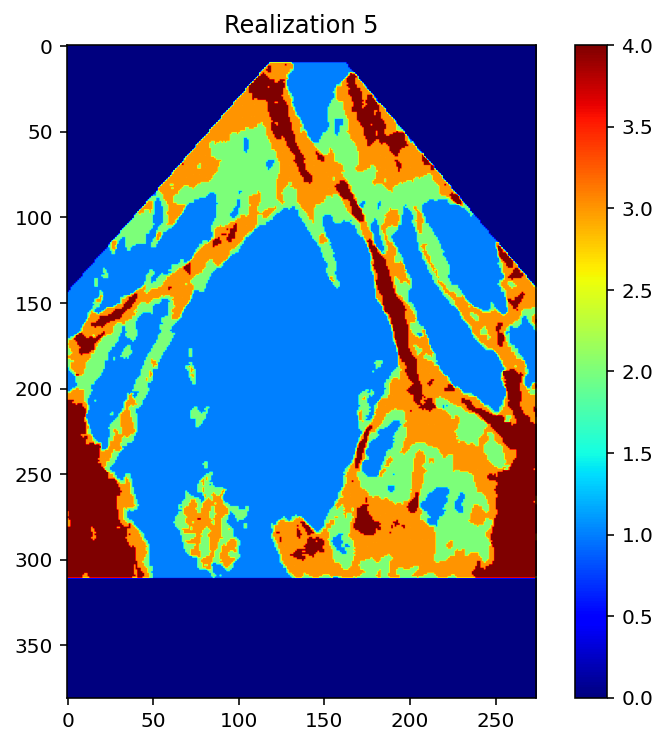

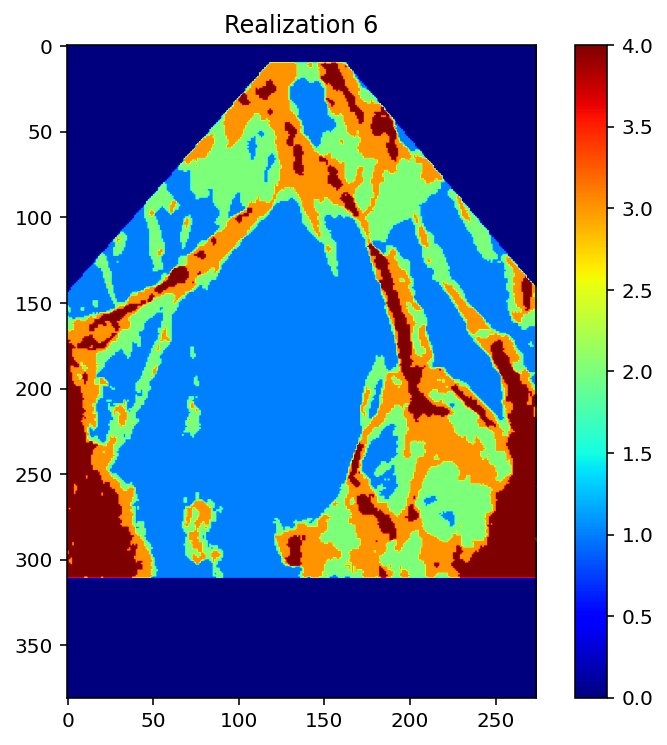

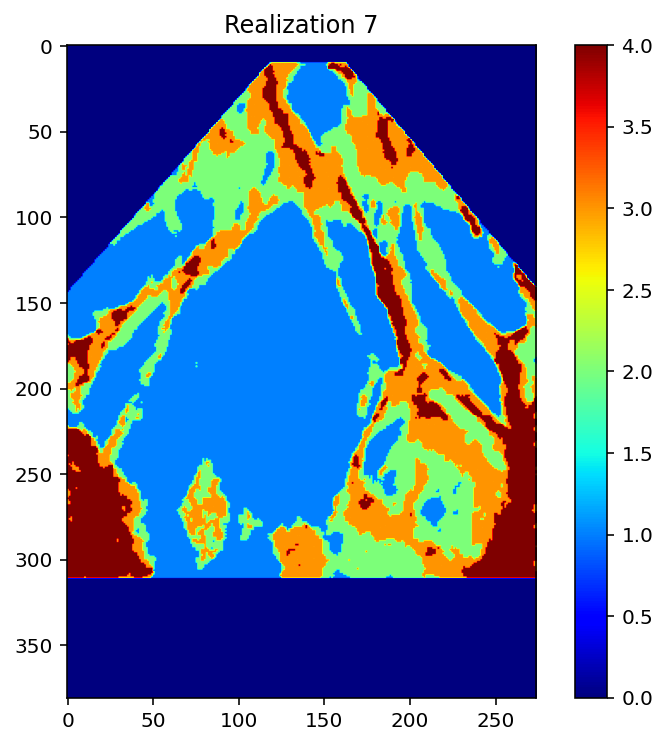

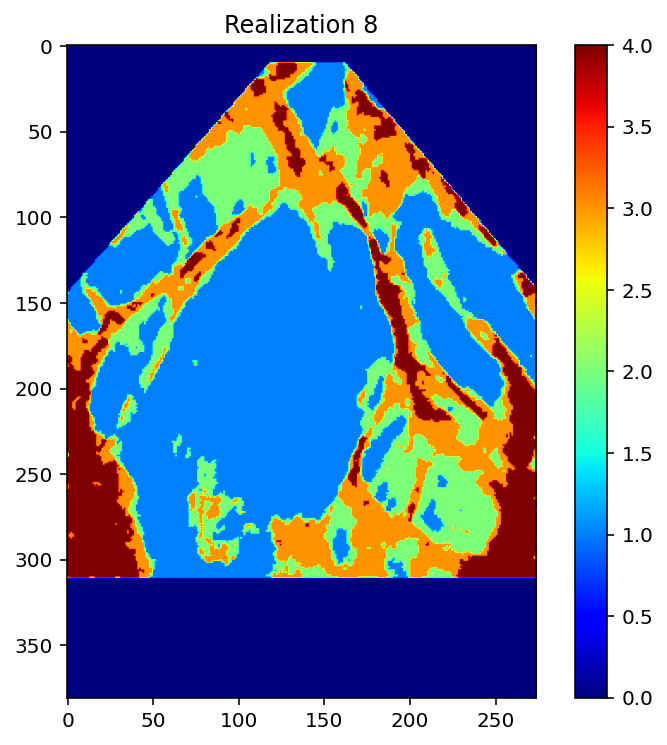

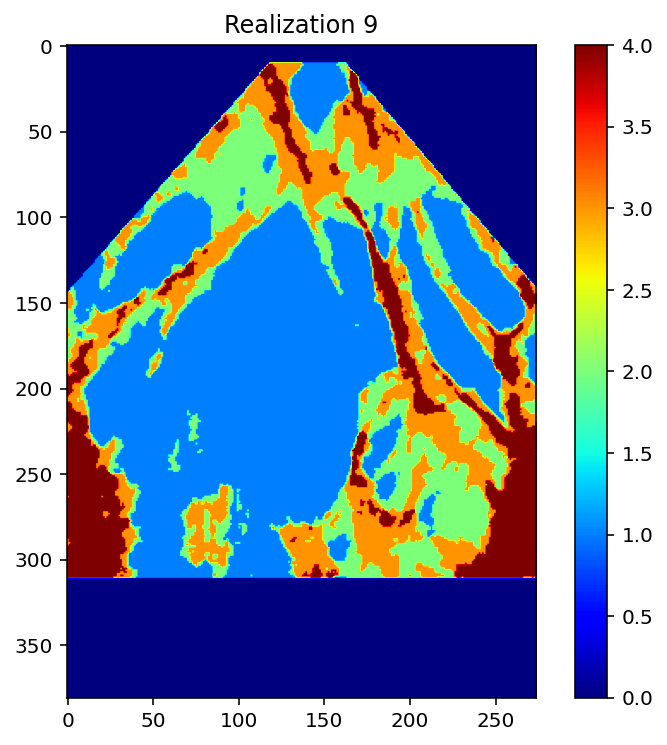

In [16]:
median_filter_template_size = 3

Realizations_Median = np.zeros((SimulationGrid_Num,
                                SimulationGrid_Height,
                                SimualtionGrid_Width))

for index_realization in range(SimulationGrid_Num):
    
    realization = np.copy(Realizations_FCNN_BallTree_TeacherStudent[index_realization])
    realization = ndimage.median_filter(realization, size = median_filter_template_size)
    
    Realizations_Median[index_realization] = np.copy(realization)
    
    plt.figure(figsize=(7,6))
    plt.imshow(realization, cmap='jet')
    plt.colorbar()
    plt.title(f'Realization {index_realization}')
    plt.show()

In [17]:
np.savetxt(fname='FlumeData_NNSIM_0.1_4categories.txt',
           X = Realizations_Median.reshape((1,-1)),
          fmt='%d',
          delimiter=',')